In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pandas as pd
import os, json

In [2]:
#reimporting data
train = keras.utils.image_dataset_from_directory(
    directory='data/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True)
train = train.prefetch(32)
test = keras.utils.image_dataset_from_directory(
    directory='data/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True)
test = test.prefetch(32)
valid = keras.utils.image_dataset_from_directory(
    directory='data/valid/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True)
valid = valid.prefetch(32)

Found 58388 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


In [3]:
#helper code
labelDict = {}
labels = os.listdir('data/test')
for i in range(len(labels)):
    labelDict[i] = labels[i]
labelDict[0]
def getSpecies(labelArray):
    return labelDict[list(labelArray).index(1)]
def dumpTrainHist(history, modelName):
    with open(f'{modelName}.json', 'w') as out:
        json.dump(history.history, out)
input_shape = (224,224,3)

In [4]:
#get model training data for comparison
models = {}
jsonFiles = [file for file in os.listdir() if file.endswith('.json')]
for file in jsonFiles:
    modelName = file[:-5]
    with open(file, 'r') as f:
        models[modelName] = json.load(f)

In [5]:
models['basicNN'].keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [6]:
#get model training data for comparison
loss = pd.DataFrame()
accuracy = pd.DataFrame()
val_loss = pd.DataFrame()
val_accuracy = pd.DataFrame()
jsonFiles = [file for file in os.listdir() if file.endswith('.json')]
jsonFiles.remove('basicNN.json') #the weird numbers on this useless model make graphing hard
for file in jsonFiles:
    modelName = file[:-5]
    with open(file, 'r') as f:
        model = json.load(f)
    loss[modelName] = model['loss']
    accuracy[modelName] = model['accuracy']
    val_loss[modelName] = model['val_loss']
    val_accuracy[modelName] = model['val_accuracy']

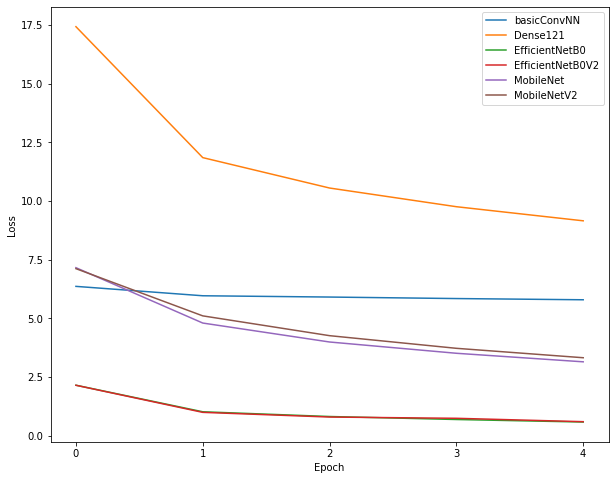

In [7]:
_=loss.plot(figsize=(10,8), xticks=range(5), xlabel='Epoch', ylabel='Loss')

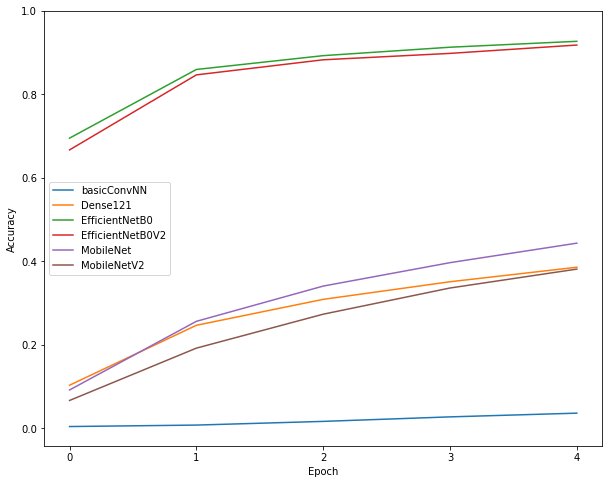

In [8]:
_=accuracy.plot(figsize=(10,8), xticks=range(5), yticks=np.arange(0,1.2,.2), xlabel='Epoch', ylabel='Accuracy')

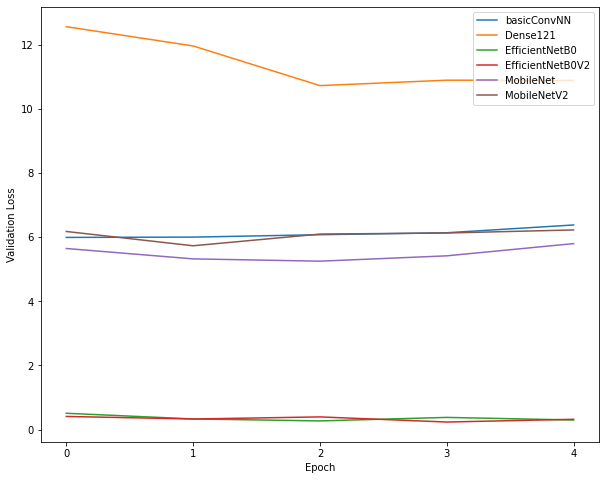

In [9]:
_=val_loss.plot(figsize=(10,8), xticks=range(5), xlabel='Epoch', ylabel='Validation Loss')

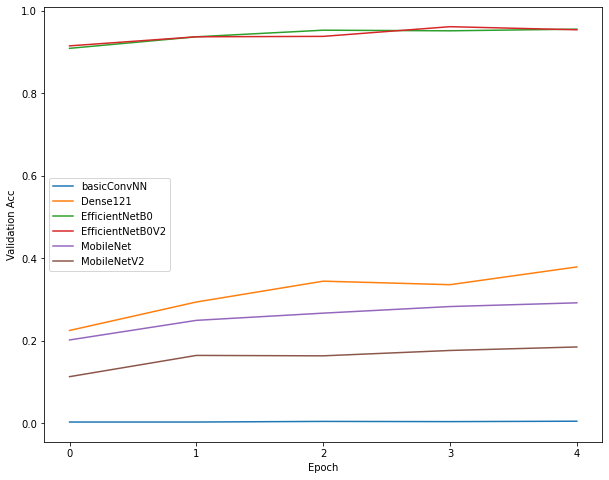

In [10]:
_=val_accuracy.plot(figsize=(10,8), xticks=range(5), xlabel='Epoch', ylabel='Validation Acc')

Based on these graphs, we will use EfficientNet, specifically EfficientNetV2 because of it's slightly lower training times.
Rather than use base level, we will use the finalized upscaled versions S/M/L
First, create models:

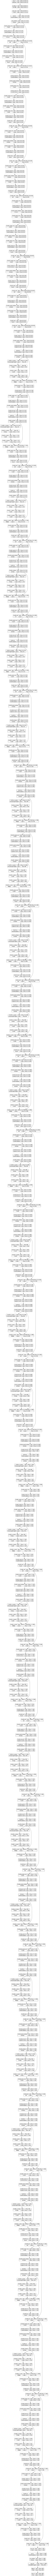

In [14]:
effNetV2SmRaw = keras.applications.EfficientNetV2S(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in effNetV2SmRaw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(effNetV2SmRaw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
effNetV2SmModel = keras.Model(effNetV2SmRaw.input, x)
effNetV2SmModel.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(effNetV2SmModel, show_shapes=True)

214201816/214201816 [==============================] - 218s 1us/step


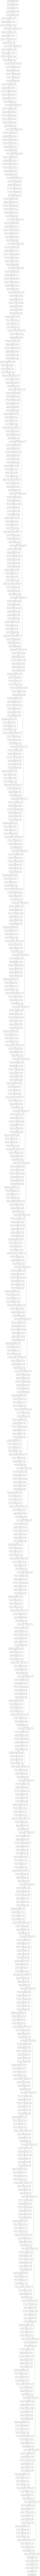

In [12]:
effNetV2MedRaw = keras.applications.EfficientNetV2M(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in effNetV2MedRaw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(effNetV2MedRaw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
effNetV2MedModel = keras.Model(effNetV2MedRaw.input, x)
effNetV2MedModel.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(effNetV2MedModel, show_shapes=True)

473176280/473176280 [==============================] - 446s 1us/step


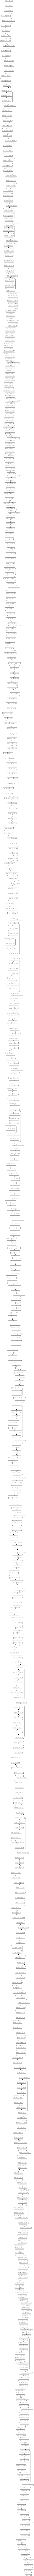

In [13]:
effNetV2LgRaw = keras.applications.EfficientNetV2L(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in effNetV2LgRaw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(effNetV2LgRaw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
effNetV2LgModel = keras.Model(effNetV2LgRaw.input, x)
effNetV2LgModel.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(effNetV2LgModel, show_shapes=True)

Train:

In [15]:
stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
effNetV2SmModel.fit(train,epochs=15,validation_data=test,callbacks=[stop])
dumpTrainHist(hist, 'EfficientNetV2Sm')

In [ ]:
effNetV2MedModel.fit(train,epochs=15,validation_data=test,callbacks=[stop])
dumpTrainHist(hist, 'EfficientNetV2Med')

In [ ]:
effNetV2LgModel.fit(train,epochs=15,validation_data=test,callbacks=[stop])
dumpTrainHist(hist, 'EfficientNetV2Lg')